# Evolutionary Machi Koro: Analysis

## Elo Rating System

Elo is a rating system that describes a player's skill relative to the rest of the field.

Let's define some functions to calculate Elo ratings.

In [5]:
K_FACTOR = 32
STARTING_RATING = 1200

def find_expected_score(rating, opponent_rating):
    """Calculate the win probability for a pairing."""
    return 1 / (1 + 10**((opponent_rating - rating) / 400))

def update_elo(rating, opponent_rating, won):
    """Determine the new rating a player gets from a single result."""
    score = 1 if won else 0
    return rating + K_FACTOR * (score - find_expected_score(rating, opponent_rating))

The world's best chess player, Magnus Carlsen,  has an Elo rating of 2843. The average club player is about 1500. What's the probability that the club player beats Carlsen?

In [6]:
find_expected_score(1500, 2843)

0.00043884319773774524

Oof. Not looking good for the club player. If (when) Magnus wins, his raiting only slightly improves.

In [7]:
update_elo(2843, 1500, True)

2843.0140429823277

The opposite result has a much larger point swing.

In [8]:
update_elo(1500, 2843, True)

1531.9859570176725

## Machi Koro Elo

Now, let's apply the Elo rating system to our Machi Koro algorithm. This will help us determine how much the strength of the computer player increases.

In [9]:
from embark.machi_koro import Game
from embark.evolution import Organism, make_random_chromosome, iterate
from embark.parameters import GENERATION_SIZE

To start, we'll simulate 100 generations of evolution and save the winner from each round.

In [10]:
generation = {Organism(make_random_chromosome()) for _ in range(GENERATION_SIZE)}
winners = []
for index in range(100):
    generation = set(iterate(generation))
    winners.append(max(generation, key=lambda organism: organism.wins))

Next, let's set the default rating on every organism.

In [11]:
for winner in winners:
    winner.rating = STARTING_RATING

Finally, let's simulate a large number of games. After each game, we'll update the player's Elo ratings.

In [12]:
from itertools import combinations

for round_number in range(1000):
    for player1, player2 in combinations(winners, 2):
        game = Game(player1, player2)
        game.simulate()
        player1.rating = update_elo(player1.rating, player2.rating, game.winner == player1)
        player2.rating = update_elo(player2.rating, player1.rating, game.winner == player2)

Here's a graph of our Elo scores per round:

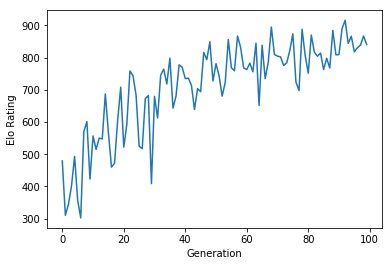

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot([winner.rating for winner in winners])
plt.ylabel('Elo Rating')
plt.xlabel('Generation')
plt.show()

Looking good! The ratings mostly increase as the genetic algorithm improves the fitness of the population.

What's the probability that the winner of the hundredth generation beats the winner of the first generation?

In [15]:
find_expected_score(winners[-1].rating, winners[0].rating)

0.8889647216454486